## Set up

In [ ]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting classifiers

In [ ]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

### The law of large numbers

Saving figure law_of_large_numbers_plot


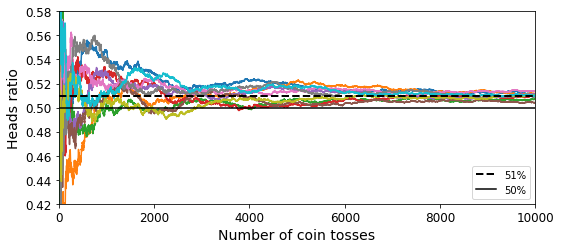

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

Let's use the moons dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Note:** to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Soft voting

In [ ]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting

### Bagging and pasting in Scikit-Learn

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


A single Decision Tree (left) versus a bagging ensemble of 500 trees (right)

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


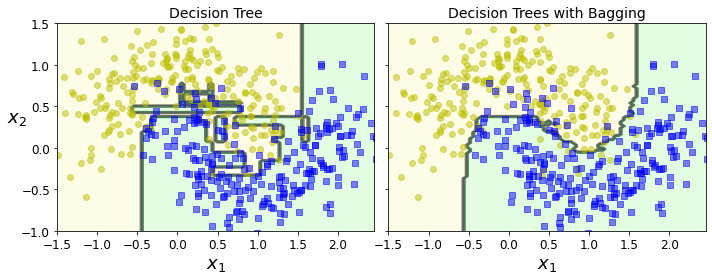

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out-of-Bag evaluation

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=42
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [ ]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539],
       [0.75586854, 0.24413146],
       [0.0049505 , 0.9950495 ],
       [0.75520833, 0.24479167],
       [0.82122905, 0.17877095],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.35087719, 0.64912281],
       [0.91111111, 0.08888889],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6635514 , 0.3364486 ],
       [0.

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

A Random Forest is equivalent to a bag of decision trees

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
    n_estimators=16, random_state=42
)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

### Feature Importance

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [ ]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

The following figure overlays the decision boundaries of 15 decision trees. As you can see, even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary

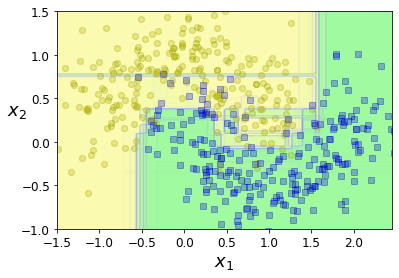

In [ ]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

**MNIST pixel importance (according to a Random Forest classifier)**

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(random_state=42)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


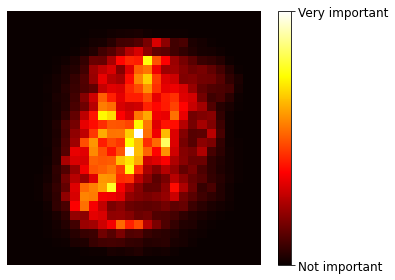

In [ ]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
save_fig('mnist_feature_importance_plot')
plt.show()


## Boosting

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

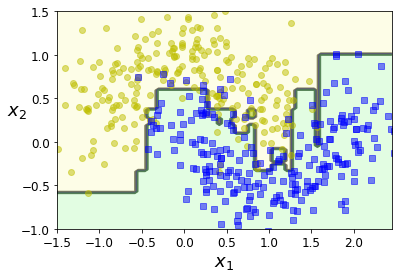

In [ ]:
plot_decision_boundary(ada_clf, X, y)

Decision boundaries of consecutive predictors

Saving figure boosting_plot


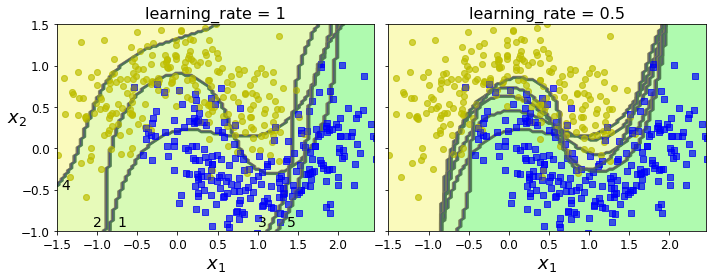

In [ ]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

### Gradient Boosting

Let's create a smple quadratic dataset

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Now let's train a decision tree regressor on this dataset

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

array([0.75026781])

In this depiction of Gradient Boosting, the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


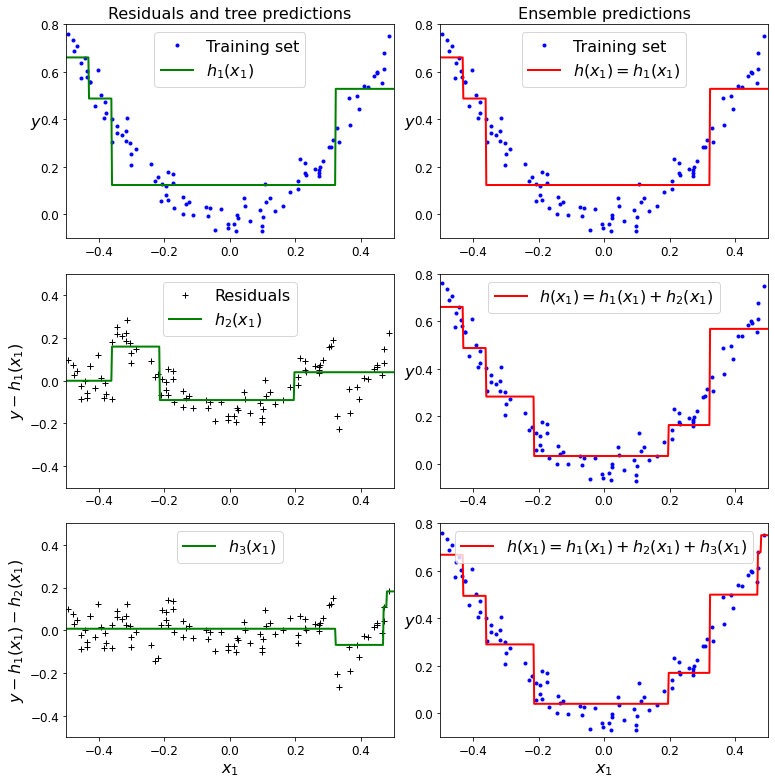

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Now let's try a gradient boosting regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

GBRT ensembles with not enough predictors (left) and too many (right)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


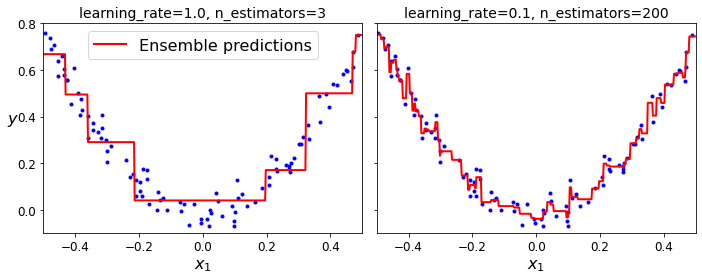

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

#### Gradient Boosting with Early stopping

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=118)

Tuning the number of trees using early stopping

In [ ]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


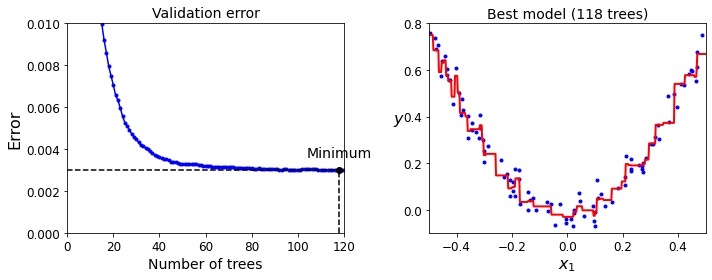

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs)

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

105


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.003023701609089896


#### Using XGBoost

In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)   

Validation MSE: 0.0030701301701716146


In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)   

[0]	validation_0-rmse:0.19678
[1]	validation_0-rmse:0.14325
[2]	validation_0-rmse:0.10835
[3]	validation_0-rmse:0.08482
[4]	validation_0-rmse:0.07044
[5]	validation_0-rmse:0.06255
[6]	validation_0-rmse:0.05927
[7]	validation_0-rmse:0.05698
[8]	validation_0-rmse:0.05519
[9]	validation_0-rmse:0.05513
[10]	validation_0-rmse:0.05474
[11]	validation_0-rmse:0.05463
[12]	validation_0-rmse:0.05427
[13]	validation_0-rmse:0.05376
[14]	validation_0-rmse:0.05377
[15]	validation_0-rmse:0.05363
[16]	validation_0-rmse:0.05358
[17]	validation_0-rmse:0.05387
Validation MSE: 0.0028706534131390338
/root/venv/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None


273 ms ± 6.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

22.4 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Voting Classifier

Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing).

### Load the MNIST dataset

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

### Train, test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

### Training

Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9604]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier.

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
voting_clf.score(X_val, y_val)

0.9698

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9604]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this

In [ ]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

This updated the list of estimators

In [ ]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

However, it did not update the list of trained estimators

In [ ]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [ ]:
del voting_clf.estimators_[2]

Now let's evaluate the VotingClassifier again

In [ ]:
voting_clf.score(X_val, y_val)

0.973

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

0.9676

Nope, hard voting wins in this case.

> Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.971

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9639]

The voting classifier only very slightly reduced the error rate of the best model in this case.

## Stacking Ensemble

Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set.

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
rnd_forest_blender.oob_score_

0.9685

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

> Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.9672

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.

In [ ]:
AdaBoostClassifier

sklearn.ensemble._weight_boosting.AdaBoostClassifier

In [ ]:
DecisionTreeClassifier

sklearn.tree._classes.DecisionTreeClassifier

In [ ]:
IMAGES_PATH

'./images/ensembles'

## Excercies

1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?

> If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that’s the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.


2. What is the difference between hard and soft voting classifiers?

> A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to  estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set `probability=True`).

3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, Random Forests, or stacking ensembles?

> It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the  predictors in the previous layer have all been trained

4. What is the benefit of out-of-bag evaluation?

> With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not  trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.

5. What makes Extra-Trees more random than regular Random Forests? How can this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?

> When you are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for Extra-Trees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don’t search  for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions.

6. If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak and how?

> If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.

7. If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?

> If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. You could also use early stopping to find the right number of predictors (you probably have too many)

8. Load the MNIST data (introduced in Chapter 3), and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM classifier. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

9. Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class. Train a classifier on this new training set. Congratulations, you have just trained a blender, and together with the classifiers it forms a stacking ensemble! Now evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions. How does it compare to the voting classifier you trained earlier?


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8b8747e0-d5e2-4759-af6a-42b7fe569db7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>